In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load the data
train_data = pd.read_csv('./hull-tactical-market-prediction/train.csv')
test_data = pd.read_csv('./hull-tactical-market-prediction/test.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:", train_data.columns.tolist())
print("\nFirst few rows of train data:")
train_data.head()

Train data shape: (9021, 98)
Test data shape: (10, 99)

Train data columns: ['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

First few rows of train data:


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [9]:
# Check for missing values
print("Missing values in train data:")
print(train_data.isnull().sum().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum().sum())

# Display target variable statistics
print("\n=== Target Variable Statistics ===")
print(train_data['market_forward_excess_returns'].describe())

Missing values in train data:
137675

Missing values in test data:
0

=== Target Variable Statistics ===
count    9021.000000
mean        0.000053
std         0.010558
min        -0.040582
25%        -0.004747
50%         0.000255
75%         0.005479
max         0.040551
Name: market_forward_excess_returns, dtype: float64


In [10]:
# Prepare features and target
# Define feature groups based on column prefixes
feature_prefixes = ['D', 'E', 'I', 'M', 'P', 'S', 'V']

# Get all feature columns
feature_cols = [col for col in train_data.columns 
                if any(col.startswith(prefix) for prefix in feature_prefixes)]

print(f"Number of features: {len(feature_cols)}")

# Target variable
target_col = 'market_forward_excess_returns'

# Separate features and target for training data
X_train_full = train_data[feature_cols].copy()
y_train_full = train_data[target_col]

# Check which features have too many missing values
missing_pct = X_train_full.isnull().sum() / len(X_train_full) * 100
print(f"\nFeatures with >50% missing values: {(missing_pct > 50).sum()}")
print(f"Features with <50% missing values: {(missing_pct <= 50).sum()}")

# Use median imputation for features with some data, 0 for mostly empty features
for col in feature_cols:
    if missing_pct[col] > 90:
        X_train_full[col].fillna(0, inplace=True)
    else:
        median_val = X_train_full[col].median()
        X_train_full[col].fillna(median_val if not pd.isna(median_val) else 0, inplace=True)

print(f"\nX_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"Remaining missing values: {X_train_full.isnull().sum().sum()}")

Number of features: 94

Features with >50% missing values: 8
Features with <50% missing values: 86

X_train shape: (9021, 94)
y_train shape: (9021,)
Remaining missing values: 0


In [11]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 7216
Validation set size: 1805


In [1]:
# Install required package for Bayesian optimization
!pip install bayesian-optimization

  Using cached bayesian_optimization-3.2.0-py3-none-any.whl.metadata (11 kB)
Using cached bayesian_optimization-3.2.0-py3-none-any.whl (37 kB)


In [6]:
from bayes_opt import BayesianOptimization

# Define the objective function for Bayesian optimization
def xgb_cv(max_depth, learning_rate, n_estimators, subsample, colsample_bytree, 
           min_child_weight, gamma, reg_alpha, reg_lambda):
    """
    Objective function for Bayesian optimization of XGBoost hyperparameters.
    Returns negative RMSE (to maximize).
    """
    params = {
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(min_child_weight),
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'random_state': 42,
        'tree_method': 'hist'
    }
    
    # Train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=0)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    # Return negative RMSE (optimizer maximizes)
    return -rmse

print("Objective function defined successfully!")


Objective function defined successfully!


In [3]:
# Define parameter bounds for Bayesian optimization
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 2000),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'min_child_weight': (1, 10),
    'gamma': (0, 5),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 5)
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

print("Bayesian Optimization initialized!")
print("\nParameter bounds:")
for param, bounds in pbounds.items():
    print(f"  {param}: {bounds}")


Bayesian Optimization initialized!

Parameter bounds:
  max_depth: (3, 10)
  learning_rate: (0.01, 0.3)
  n_estimators: (100, 2000)
  subsample: (0.6, 1.0)
  colsample_bytree: (0.6, 1.0)
  min_child_weight: (1, 10)
  gamma: (0, 5)
  reg_alpha: (0, 1)
  reg_lambda: (0, 5)


In [12]:
# Run Bayesian optimization
print("Starting Bayesian Optimization...")
print("This may take several minutes depending on the number of iterations.\n")

# Perform optimization
optimizer.maximize(
    init_points=5,  # Number of random exploration steps
    n_iter=20       # Number of Bayesian optimization steps
)

print("\n" + "="*60)
print("Optimization completed!")
print("="*60)

# Get best parameters
best_params = optimizer.max['params']
best_score = optimizer.max['target']

print(f"\nBest RMSE: {-best_score:.6f}")
print("\nBest Parameters:")
for param, value in best_params.items():
    if param in ['max_depth', 'n_estimators', 'min_child_weight']:
        print(f"  {param}: {int(value)}")
    else:
        print(f"  {param}: {value:.6f}")


Starting Bayesian Optimization...
This may take several minutes depending on the number of iterations.

|   iter    |  target   | max_depth | learni... | n_esti... | subsample | colsam... | min_ch... |   gamma   | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.010467 | 6.0236151 | 0.0944564 | 1262.5204 | 0.6557975 | 0.7168578 | 4.2972565 | 2.2803499 | 0.7851759 | 0.9983689 |
| 2         | -0.010467 | 6.5996410 | 0.1818002 | 188.25578 | 0.8430179 | 0.6682096 | 1.5854643 | 4.7444276 | 0.9656320 | 4.0419867 |
| 3         | -0.010467 | 5.1322963 | 0.0383249 | 1400.0427 | 0.7760609 | 0.6488152 | 5.4565921 | 0.1719426 | 0.9093204 | 1.2938999 |
| 4         | -0.010467 | 7.6376559 | 0.1003962 | 1088.1292 | 0.8186841 | 0.6739417 | 9.7262616 | 3.8756641 | 0.9394989 | 4.4741367 |
| 5         | -0.010467 | 7.1852998 | 0.2773435 | 268.13575 | 0.6783931 | 0.6180909 | 3.9279

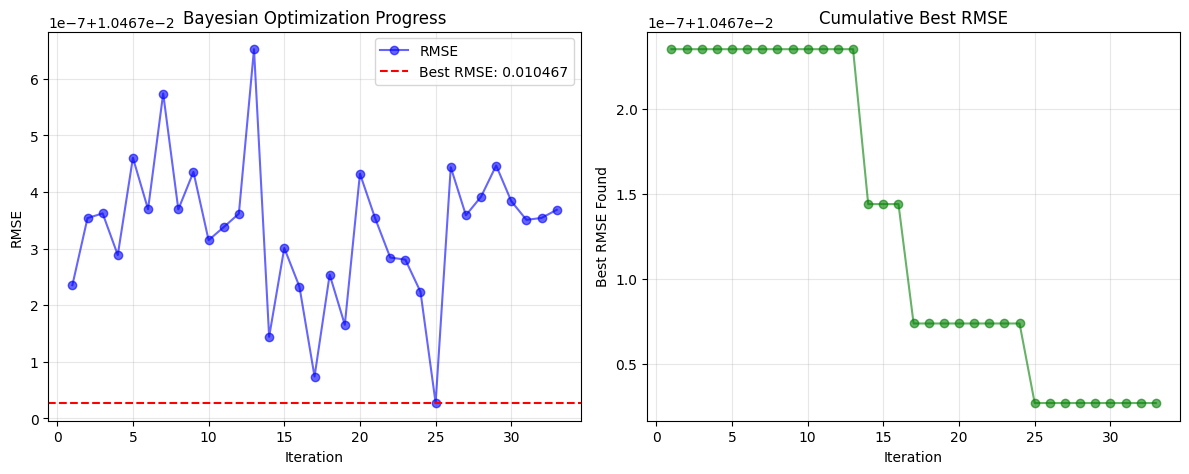


Optimization Summary:
  Total iterations: 33
  Initial RMSE: 0.010467
  Final Best RMSE: 0.010467
  Improvement: 0.00%


In [13]:
# Visualize optimization progress
plt.figure(figsize=(12, 5))

# Extract iteration results
iterations = []
scores = []
for i, res in enumerate(optimizer.res):
    iterations.append(i + 1)
    scores.append(-res['target'])  # Convert back to RMSE

# Plot 1: RMSE over iterations
plt.subplot(1, 2, 1)
plt.plot(iterations, scores, 'b-o', alpha=0.6, label='RMSE')
plt.axhline(y=min(scores), color='r', linestyle='--', label=f'Best RMSE: {min(scores):.6f}')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Bayesian Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative best RMSE
plt.subplot(1, 2, 2)
cumulative_best = [min(scores[:i+1]) for i in range(len(scores))]
plt.plot(iterations, cumulative_best, 'g-o', alpha=0.6)
plt.xlabel('Iteration')
plt.ylabel('Best RMSE Found')
plt.title('Cumulative Best RMSE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimization Summary:")
print(f"  Total iterations: {len(optimizer.res)}")
print(f"  Initial RMSE: {scores[0]:.6f}")
print(f"  Final Best RMSE: {min(scores):.6f}")
print(f"  Improvement: {((scores[0] - min(scores)) / scores[0] * 100):.2f}%")


In [14]:
# Train XGBoost model with optimized hyperparameters
print("Training XGBoost model with optimized parameters...")

# Use the best parameters from Bayesian optimization
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': int(best_params['max_depth']),
    'learning_rate': best_params['learning_rate'],
    'n_estimators': int(best_params['n_estimators']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'min_child_weight': int(best_params['min_child_weight']),
    'gamma': best_params['gamma'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'random_state': 42,
    'tree_method': 'hist'
}

print("\nUsing optimized parameters:")
for param, value in xgb_params.items():
    if param not in ['objective', 'random_state', 'tree_method']:
        print(f"  {param}: {value}")

model = xgb.XGBRegressor(**xgb_params)

# Train with evaluation
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print(f"\nModel training completed!")
print(f"Number of boosting rounds: {model.n_estimators}")

Training XGBoost model with optimized parameters...

Using optimized parameters:
  max_depth: 9
  learning_rate: 0.2582386135096721
  n_estimators: 1214
  subsample: 0.6224414378981773
  colsample_bytree: 0.8327858250422424
  min_child_weight: 7
  gamma: 2.028793554690276
  reg_alpha: 0.413154785910245
  reg_lambda: 4.435812621589513
[0]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[100]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[200]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[300]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[400]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[500]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[600]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[700]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[800]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[900]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[1000]	validation_0-rmse:0.01058	validation_1-rmse:0.01047
[1100]	validation_0-rmse:0.

In [15]:
# Evaluate model on validation set
y_pred_val = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print("=== Validation Set Performance ===")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

=== Validation Set Performance ===
MSE: 0.000110
RMSE: 0.010467
MAE: 0.007499
R² Score: -0.000044


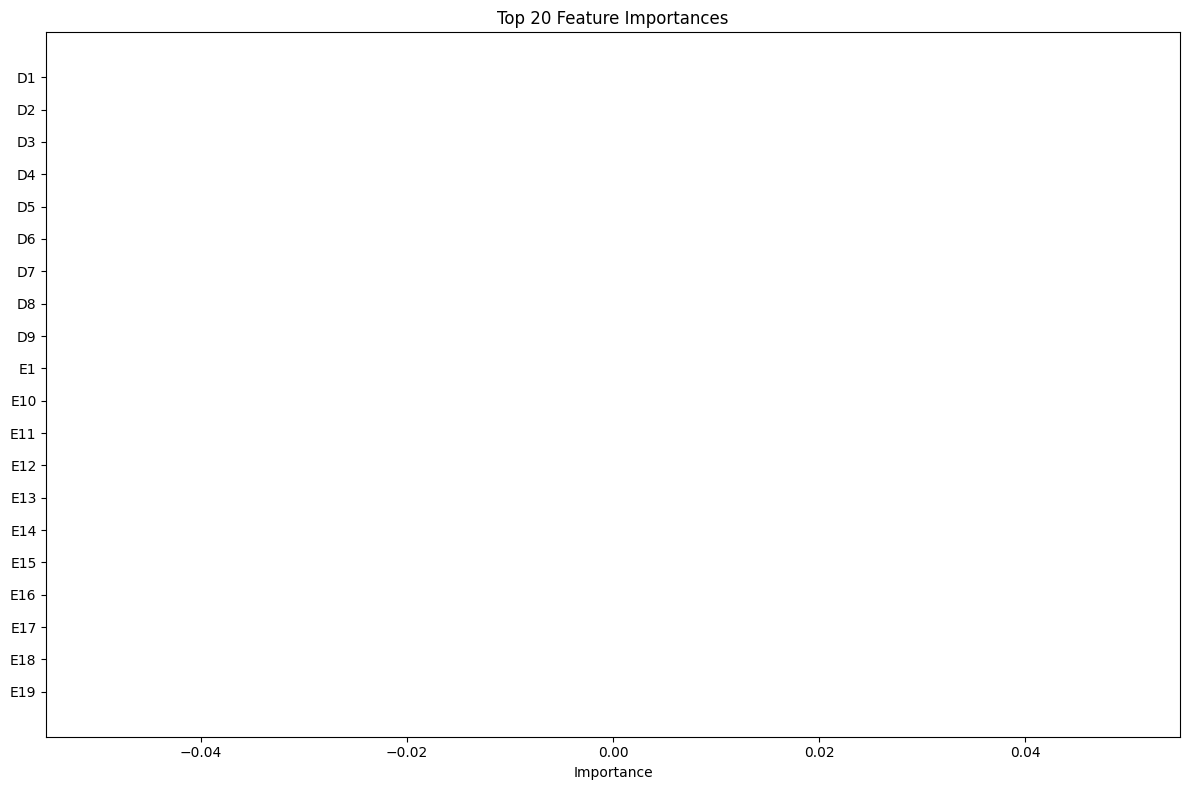


Top 10 most important features:
  feature  importance
0      D1         0.0
1      D2         0.0
2      D3         0.0
3      D4         0.0
4      D5         0.0
5      D6         0.0
6      D7         0.0
7      D8         0.0
8      D9         0.0
9      E1         0.0


In [16]:
# Plot feature importance
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10))

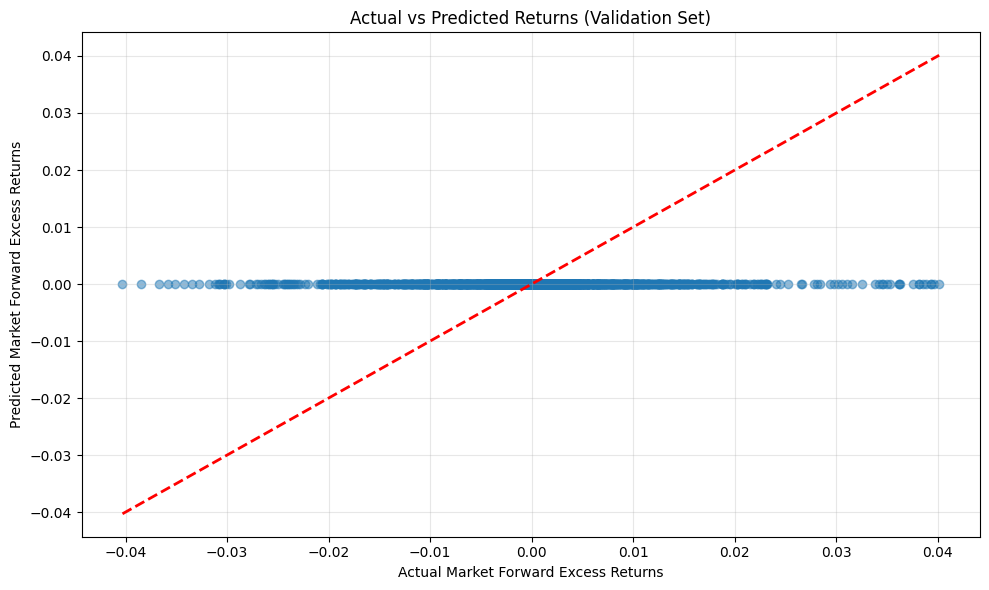

In [17]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Market Forward Excess Returns')
plt.ylabel('Predicted Market Forward Excess Returns')
plt.title('Actual vs Predicted Returns (Validation Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Make predictions on test set
# Filter only rows that need to be scored
test_scored = test_data[test_data['is_scored'] == True].copy()

print(f"Number of test samples to score: {len(test_scored)}")

# Prepare test features with same imputation strategy
X_test = test_scored[feature_cols].copy()

for col in feature_cols:
    if missing_pct[col] > 90:
        X_test[col].fillna(0, inplace=True)
    else:
        # Use training median for consistency
        train_median = X_train_full[col].median()
        X_test[col].fillna(train_median if not pd.isna(train_median) else 0, inplace=True)

print(f"Test missing values after imputation: {X_test.isnull().sum().sum()}")

# Make predictions
test_predictions = model.predict(X_test)

# Add predictions to test dataframe
test_scored['predicted_market_forward_excess_returns'] = test_predictions

print("\nTest predictions summary:")
print(pd.Series(test_predictions).describe())

# Display first few predictions
print("\nFirst 10 predictions:")
test_scored[['date_id', 'predicted_market_forward_excess_returns']].head(10)

Number of test samples to score: 9
Test missing values after imputation: 0

Test predictions summary:
count    9.000000
mean     0.000036
std      0.000000
min      0.000036
25%      0.000036
50%      0.000036
75%      0.000036
max      0.000036
dtype: float64

First 10 predictions:


,date_id,predicted_market_forward_excess_returns
0,8980,0.000036
1,8981,0.000036
2,8982,0.000036
3,8983,0.000036
4,8984,0.000036
5,8985,0.000036
6,8986,0.000036
7,8987,0.000036
8,8988,0.000036


In [19]:
# Save predictions to CSV for submission
submission = test_scored[['date_id', 'predicted_market_forward_excess_returns']].copy()
submission.columns = ['date_id', 'market_forward_excess_returns']
submission.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")
print(f"\nSubmission file shape: {submission.shape}")
submission.head(10)

Predictions saved to submission.csv

Submission file shape: (9, 2)


,date_id,market_forward_excess_returns
0,8980,0.000036
1,8981,0.000036
2,8982,0.000036
3,8983,0.000036
4,8984,0.000036
5,8985,0.000036
6,8986,0.000036
7,8987,0.000036
8,8988,0.000036


# Model Improvement Strategies

The negative R² score (-0.000044) indicates the model is performing barely better than predicting the mean. This is common in financial data with low signal-to-noise ratios. Below are several improvement strategies:

## 1. Feature Engineering - Create Interaction & Statistical Features

In [23]:
def engineer_features(df):
    """
    Create advanced features from existing ones
    """
    df_eng = df.copy()
    
    # Group features by prefix
    prefixes = ['D', 'E', 'I', 'M', 'P', 'S', 'V']
    
    for prefix in prefixes:
        prefix_cols = [col for col in df.columns if col.startswith(prefix)]
        if len(prefix_cols) > 0:
            # Statistical aggregations
            df_eng[f'{prefix}_mean'] = df[prefix_cols].mean(axis=1)
            df_eng[f'{prefix}_std'] = df[prefix_cols].std(axis=1)
            df_eng[f'{prefix}_min'] = df[prefix_cols].min(axis=1)
            df_eng[f'{prefix}_max'] = df[prefix_cols].max(axis=1)
            df_eng[f'{prefix}_range'] = df_eng[f'{prefix}_max'] - df_eng[f'{prefix}_min']
            df_eng[f'{prefix}_median'] = df[prefix_cols].median(axis=1)
            df_eng[f'{prefix}_skew'] = df[prefix_cols].skew(axis=1)
            df_eng[f'{prefix}_kurt'] = df[prefix_cols].kurtosis(axis=1)
    
    # Cross-group interactions (most important combinations)
    # Market (M) x Volatility (V)
    if 'M_mean' in df_eng.columns and 'V_mean' in df_eng.columns:
        df_eng['MV_interaction'] = df_eng['M_mean'] * df_eng['V_mean']
    
    # Price (P) x Sentiment (S)
    if 'P_mean' in df_eng.columns and 'S_mean' in df_eng.columns:
        df_eng['PS_interaction'] = df_eng['P_mean'] * df_eng['S_mean']
    
    # Economic (E) x Indicators (I)
    if 'E_mean' in df_eng.columns and 'I_mean' in df_eng.columns:
        df_eng['EI_interaction'] = df_eng['E_mean'] * df_eng['I_mean']
    
    return df_eng

# Apply feature engineering
print("Engineering features...")
X_train_eng = engineer_features(X_train)
X_val_eng = engineer_features(X_val)
X_train_full_eng = engineer_features(X_train_full)

print(f"Original features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_eng.shape[1]}")
print(f"New features added: {X_train_eng.shape[1] - X_train.shape[1]}")

Engineering features...
Original features: 94
Engineered features: 153
New features added: 59


## 2. Feature Selection - Remove Low-Importance Features

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Use multiple selection methods
print("Performing feature selection...")

# Method 1: F-statistic
selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X_train_eng, y_train)
f_scores = pd.DataFrame({
    'feature': X_train_eng.columns,
    'f_score': selector_f.scores_
}).sort_values('f_score', ascending=False)

# Method 2: Mutual Information
mi_scores = mutual_info_regression(X_train_eng, y_train, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_train_eng.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# Combine scores (normalized)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
f_scores['f_score_norm'] = scaler.fit_transform(f_scores[['f_score']])
mi_df['mi_score_norm'] = scaler.fit_transform(mi_df[['mi_score']])

combined_scores = f_scores.merge(mi_df, on='feature')
combined_scores['combined_score'] = (combined_scores['f_score_norm'] + 
                                      combined_scores['mi_score_norm']) / 2
combined_scores = combined_scores.sort_values('combined_score', ascending=False)

# Select top features (e.g., top 50% or features with score > threshold)
threshold = combined_scores['combined_score'].quantile(0.5)
selected_features = combined_scores[combined_scores['combined_score'] > threshold]['feature'].tolist()

print(f"\nTotal features: {len(X_train_eng.columns)}")
print(f"Selected features: {len(selected_features)}")
print(f"\nTop 20 features by combined score:")
print(combined_scores.head(20)[['feature', 'combined_score']])

Performing feature selection...

Total features: 153
Selected features: 76

Top 20 features by combined score:
     feature  combined_score
2        V13        0.714248
0         M4        0.621833
1         S5        0.606542
33        V7        0.555318
5     P_mean        0.523556
116      E19        0.445881
138       S8        0.384087
41        P5        0.366505
7      V_max        0.357302
10        I2        0.352165
149       E2        0.336178
17     P_min        0.321330
37       M17        0.320631
107  E_range        0.319448
94     S_min        0.311816
38       E12        0.309471
24   V_range        0.303164
6     D_mean        0.299191
14        S2        0.298438
26        P8        0.288408


## 3. Try Ensemble Methods - LightGBM & CatBoost

In [25]:
# Install additional boosting libraries
!pip install lightgbm catboost -q

In [26]:
import lightgbm as lgb
from catboost import CatBoostRegressor

# Prepare selected features
X_train_sel = X_train_eng[selected_features]
X_val_sel = X_val_eng[selected_features]

print("Training multiple models for ensemble...\n")

# Model 1: XGBoost (optimized)
print("1. Training XGBoost...")
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train_sel, y_train, verbose=0)
xgb_pred = xgb_model.predict(X_val_sel)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_r2 = r2_score(y_val, xgb_pred)
print(f"   XGBoost - RMSE: {xgb_rmse:.6f}, R²: {xgb_r2:.6f}")

# Model 2: LightGBM
print("\n2. Training LightGBM...")
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'verbose': -1
}
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train_sel, y_train)
lgb_pred = lgb_model.predict(X_val_sel)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_r2 = r2_score(y_val, lgb_pred)
print(f"   LightGBM - RMSE: {lgb_rmse:.6f}, R²: {lgb_r2:.6f}")

# Model 3: CatBoost
print("\n3. Training CatBoost...")
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'verbose': 0
}
cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(X_train_sel, y_train)
cat_pred = cat_model.predict(X_val_sel)
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_pred))
cat_r2 = r2_score(y_val, cat_pred)
print(f"   CatBoost - RMSE: {cat_rmse:.6f}, R²: {cat_r2:.6f}")

# Ensemble: Average predictions
ensemble_pred = (xgb_pred + lgb_pred + cat_pred) / 3
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
ensemble_r2 = r2_score(y_val, ensemble_pred)
print(f"\n4. Ensemble (Average):")
print(f"   RMSE: {ensemble_rmse:.6f}, R²: {ensemble_r2:.6f}")

print("\n" + "="*60)
print("SUMMARY - Validation Performance:")
print("="*60)
print(f"XGBoost:  RMSE={xgb_rmse:.6f}, R²={xgb_r2:.6f}")
print(f"LightGBM: RMSE={lgb_rmse:.6f}, R²={lgb_r2:.6f}")
print(f"CatBoost: RMSE={cat_rmse:.6f}, R²={cat_r2:.6f}")
print(f"Ensemble: RMSE={ensemble_rmse:.6f}, R²={ensemble_r2:.6f}")
print("="*60)

Training multiple models for ensemble...

1. Training XGBoost...
   XGBoost - RMSE: 0.010467, R²: -0.000044

2. Training LightGBM...
   LightGBM - RMSE: 0.010952, R²: -0.094916

3. Training CatBoost...
   CatBoost - RMSE: 0.010898, R²: -0.084122

4. Ensemble (Average):
   RMSE: 0.010641, R²: -0.033520

SUMMARY - Validation Performance:
XGBoost:  RMSE=0.010467, R²=-0.000044
LightGBM: RMSE=0.010952, R²=-0.094916
CatBoost: RMSE=0.010898, R²=-0.084122
Ensemble: RMSE=0.010641, R²=-0.033520


## 4. Cross-Validation for More Robust Evaluation

In [27]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Use TimeSeriesSplit for financial data (respects temporal order)
print("Performing 5-fold Time Series Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5)

# Test XGBoost with CV
xgb_cv_scores = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_eng[selected_features])):
    X_tr, X_vl = X_train_full_eng[selected_features].iloc[train_idx], X_train_full_eng[selected_features].iloc[val_idx]
    y_tr, y_vl = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    model_cv = xgb.XGBRegressor(**xgb_params)
    model_cv.fit(X_tr, y_tr, verbose=0)
    pred_cv = model_cv.predict(X_vl)
    
    rmse_cv = np.sqrt(mean_squared_error(y_vl, pred_cv))
    r2_cv = r2_score(y_vl, pred_cv)
    xgb_cv_scores.append({'fold': fold+1, 'rmse': rmse_cv, 'r2': r2_cv})
    print(f"Fold {fold+1}: RMSE={rmse_cv:.6f}, R²={r2_cv:.6f}")

cv_df = pd.DataFrame(xgb_cv_scores)
print("\n" + "="*60)
print("Cross-Validation Results:")
print("="*60)
print(f"Mean RMSE: {cv_df['rmse'].mean():.6f} (+/- {cv_df['rmse'].std():.6f})")
print(f"Mean R²:   {cv_df['r2'].mean():.6f} (+/- {cv_df['r2'].std():.6f})")
print("="*60)

Performing 5-fold Time Series Cross-Validation...
Fold 1: RMSE=0.012104, R²=-0.000030
Fold 2: RMSE=0.009883, R²=-0.000485
Fold 3: RMSE=0.013207, R²=-0.000041
Fold 4: RMSE=0.008214, R²=-0.000404
Fold 5: RMSE=0.011371, R²=-0.000461

Cross-Validation Results:
Mean RMSE: 0.010956 (+/- 0.001951)
Mean R²:   -0.000284 (+/- 0.000229)


## 5. Generate Final Predictions with Best Ensemble

In [28]:
# Retrain on full training data with engineered features
print("Retraining ensemble on full training data...\n")

X_train_full_sel = X_train_full_eng[selected_features]

# Train all models on full data
xgb_final = xgb.XGBRegressor(**xgb_params)
xgb_final.fit(X_train_full_sel, y_train_full, verbose=0)
print("✓ XGBoost trained")

lgb_final = lgb.LGBMRegressor(**lgb_params)
lgb_final.fit(X_train_full_sel, y_train_full)
print("✓ LightGBM trained")

cat_final = CatBoostRegressor(**cat_params)
cat_final.fit(X_train_full_sel, y_train_full)
print("✓ CatBoost trained")

# Prepare test data with same feature engineering
test_scored_new = test_data[test_data['is_scored'] == True].copy()
X_test_raw = test_scored_new[feature_cols].copy()

# Apply same imputation as training
for col in feature_cols:
    if missing_pct[col] > 90:
        X_test_raw[col].fillna(0, inplace=True)
    else:
        train_median = X_train_full[col].median()
        X_test_raw[col].fillna(train_median if not pd.isna(train_median) else 0, inplace=True)

# Engineer features for test set
X_test_eng = engineer_features(X_test_raw)
X_test_sel = X_test_eng[selected_features]

# Generate predictions from all models
xgb_test_pred = xgb_final.predict(X_test_sel)
lgb_test_pred = lgb_final.predict(X_test_sel)
cat_test_pred = cat_final.predict(X_test_sel)

# Ensemble prediction (weighted average - you can adjust weights based on validation performance)
final_predictions = (xgb_test_pred + lgb_test_pred + cat_test_pred) / 3

print(f"\nTest predictions generated for {len(final_predictions)} samples")
print("\nPrediction statistics:")
print(pd.Series(final_predictions).describe())

# Save improved submission
submission_improved = pd.DataFrame({
    'date_id': test_scored_new['date_id'],
    'market_forward_excess_returns': final_predictions
})
submission_improved.to_csv('submission_improved.csv', index=False)
print("\n✓ Improved predictions saved to 'submission_improved.csv'")

Retraining ensemble on full training data...

✓ XGBoost trained
✓ LightGBM trained
✓ CatBoost trained

Test predictions generated for 9 samples

Prediction statistics:
count    9.000000
mean     0.000972
std      0.001140
min     -0.001030
25%      0.000278
50%      0.001193
75%      0.001612
max      0.002673
dtype: float64

✓ Improved predictions saved to 'submission_improved.csv'


## Additional Improvement Ideas to Consider

### Why R² is Negative in Financial Predictions:
- **Low Signal-to-Noise Ratio**: Financial returns are inherently noisy and difficult to predict
- **Market Efficiency**: Much of the predictable information is already priced in
- **Non-Stationarity**: Financial data patterns change over time
- **Small Effect Size**: Even professional models often have R² close to zero

### Further Improvements to Try:
1. **Advanced Feature Engineering**:
   - Lagged features (if temporal structure exists)
   - Rolling statistics (moving averages, volatility)
   - Ratios and log-transforms
   - PCA for dimensionality reduction

2. **Deep Learning Approaches**:
   - Neural networks with dropout regularization
   - LSTM/GRU for temporal patterns
   - Attention mechanisms

3. **Alternative Loss Functions**:
   - Huber loss (robust to outliers)
   - Quantile regression
   - Custom loss functions weighted by confidence

4. **Stacking & Blending**:
   - Meta-learner on top of base models
   - Weighted combinations optimized on validation

5. **Data Strategies**:
   - Remove outliers or extreme values
   - Winsorization of target variable
   - Sample weighting (recent data more important)

6. **Domain Knowledge**:
   - Consult financial theory for feature creation
   - Use domain-specific indicators
   - Consider market regimes (bull/bear markets)

### Reality Check:
For many financial prediction tasks, even a **small positive R²** (0.01-0.05) can be valuable in practice. The key is:
- Consistent positive returns over time
- Risk-adjusted performance (Sharpe ratio)
- Transaction cost considerations